In [1]:
import numpy as np
import json
import os
import matplotlib.pyplot as plt
import librosa
import librosa.display

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

2025-05-30 20:37:36.062972: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def plot_mfcc(mfcc, fs):
    plt.figure(figsize=(12,6))
    librosa.display.specshow(data=mfcc, sr=fs, x_axis='time', y_axis='linear', cmap='viridis')
    plt.title('MFCCs')
    plt.colorbar(format='%+02.0f dB')
    plt.tight_layout()


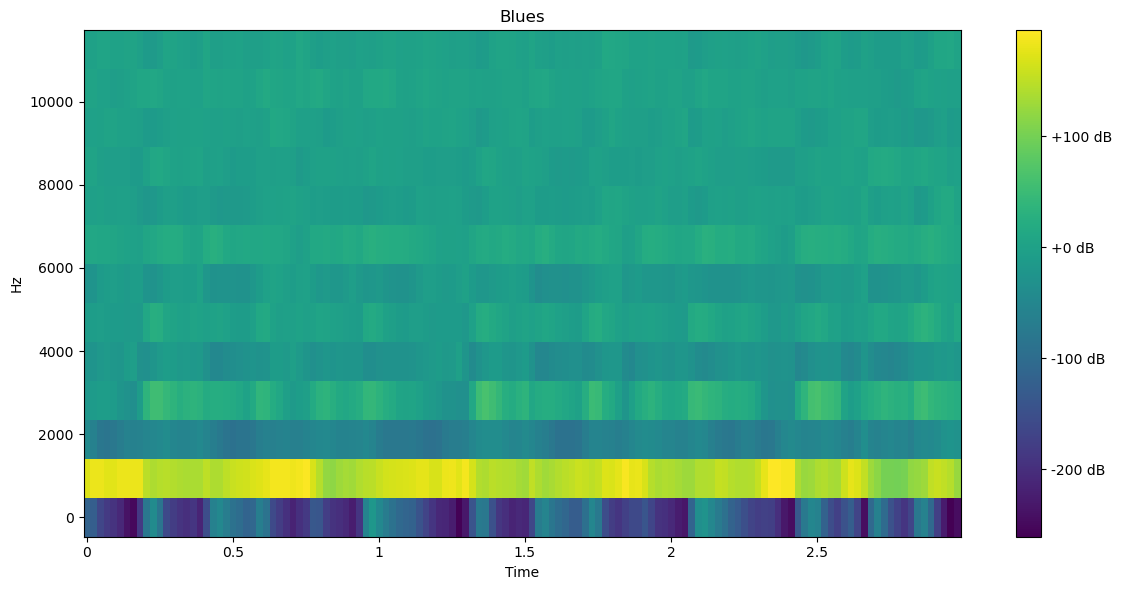

In [3]:
path="/home/efectn/python-music-classification"
json_path = path+"/dataset/features_3.0_sec.json"

with open(json_path, "r") as fp:
    data = json.load(fp)

idx = 100
fs = 22500

mfcc_sample = np.array(data["mfcc"])[idx].T
plot_mfcc(mfcc_sample, fs)

if "genre_name" in data:
    plt.title(f"{np.array(data['genre_name'])[idx].title()}")
else:
    plt.title(f"Sample #{idx}")

In [4]:
X = np.array(data["mfcc"])
y = np.array(data["genre_num"])

print("MFCC şekli:", X.shape)
print("Etiket şekli:", y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

print("Eğitim verisi şekli:", X_train.shape)
print("Doğrulama verisi şekli:", X_val.shape)

MFCC şekli: (9989, 132, 13)
Etiket şekli: (9989,)
Eğitim verisi şekli: (5593, 132, 13)
Doğrulama verisi şekli: (1399, 132, 13)


In [5]:
model_lstm = Sequential()

model_lstm.add(LSTM(128, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model_lstm.add(Dropout(0.3))
model_lstm.add(LSTM(64))
model_lstm.add(Dropout(0.3))
model_lstm.add(Dense(64, activation='relu'))
model_lstm.add(Dropout(0.3))
model_lstm.add(Dense(10, activation='softmax'))

model_lstm.compile(loss='sparse_categorical_crossentropy',
                   optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                   metrics=['accuracy'])

model_lstm.summary()

2025-05-30 20:39:04.061156: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 132, 128)          72704     
                                                                 
 dropout (Dropout)           (None, 132, 128)          0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                6

In [6]:
from tensorflow.python.keras.callbacks import ReduceLROnPlateau

early_stop = EarlyStopping(patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(patience=5, factor=0.5)

history = model_lstm.fit(X_train, y_train,
                         validation_data=(X_val, y_val),
                         epochs=100,
                         batch_size=32,
                         verbose=1,
                         callbacks=[early_stop, reduce_lr],
                         )

Epoch 1/100
175/175 [==============================] - 18s 89ms/step - loss: 2.2649 - accuracy: 0.1470 - val_loss: 2.1231 - val_accuracy: 0.2966 - lr: 1.0000e-04
Epoch 2/100
175/175 [==============================] - 15s 85ms/step - loss: 2.0647 - accuracy: 0.2716 - val_loss: 1.8801 - val_accuracy: 0.3317 - lr: 1.0000e-04
Epoch 3/100
175/175 [==============================] - 15s 87ms/step - loss: 1.8940 - accuracy: 0.3376 - val_loss: 1.7096 - val_accuracy: 0.3874 - lr: 1.0000e-04
Epoch 4/100
175/175 [==============================] - 15s 87ms/step - loss: 1.7476 - accuracy: 0.3907 - val_loss: 1.5688 - val_accuracy: 0.4489 - lr: 1.0000e-04
Epoch 5/100
175/175 [==============================] - 15s 88ms/step - loss: 1.6478 - accuracy: 0.4175 - val_loss: 1.4547 - val_accuracy: 0.4996 - lr: 1.0000e-04
Epoch 6/100
175/175 [==============================] - 16s 91ms/step - loss: 1.5590 - accuracy: 0.4482 - val_loss: 1.3872 - val_accuracy: 0.5275 - lr: 1.0000e-04
Epoch 7/100
175/175 [=======

94/94 [==============================] - 2s 24ms/step - loss: 0.9472 - accuracy: 0.7384
Test Loss: 0.947158694267273
Test Accuracy: 0.7384050488471985


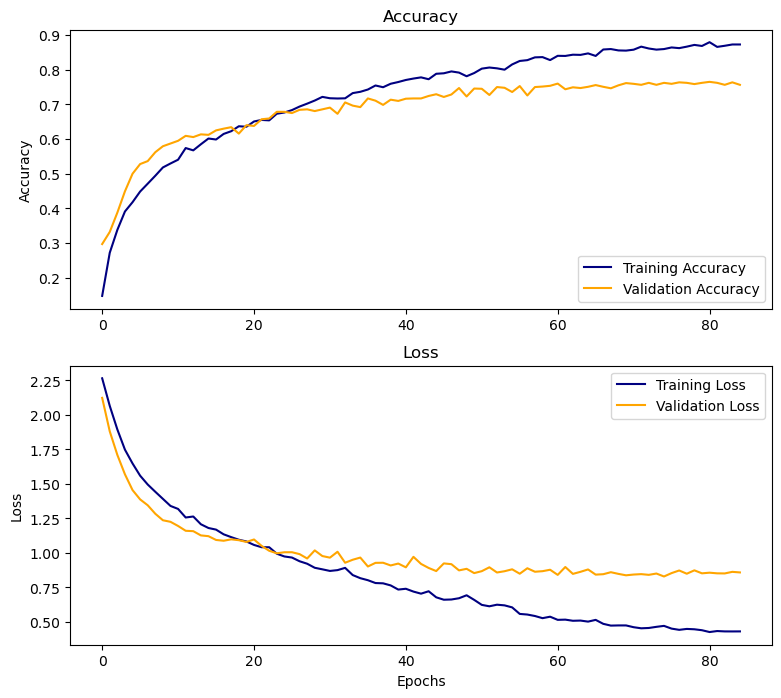

In [8]:
def plot_history(hist):
    fig, axs = plt.subplots(2, 1, figsize=(8,7))
    fig.tight_layout(pad=2)
    
    axs[0].plot(hist.history["accuracy"], c='navy', label="Training Accuracy")
    axs[0].plot(hist.history["val_accuracy"], c='orange', label="Validation Accuracy")    
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy")
    
    axs[1].plot(hist.history["loss"], c='navy', label="Training Loss")
    axs[1].plot(hist.history["val_loss"], c='orange', label="Validation Loss")    
    axs[1].set_ylabel("Loss")
    axs[1].set_xlabel("Epochs")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Loss")
    
    plt.show()

loss_lstm, acc_lstm = model_lstm.evaluate(X_test, y_test)
print(f"Test Loss: {loss_lstm}")
print(f"Test Accuracy: {acc_lstm}")

plot_history(history)

1/1 [==============================] - 0s 18ms/step


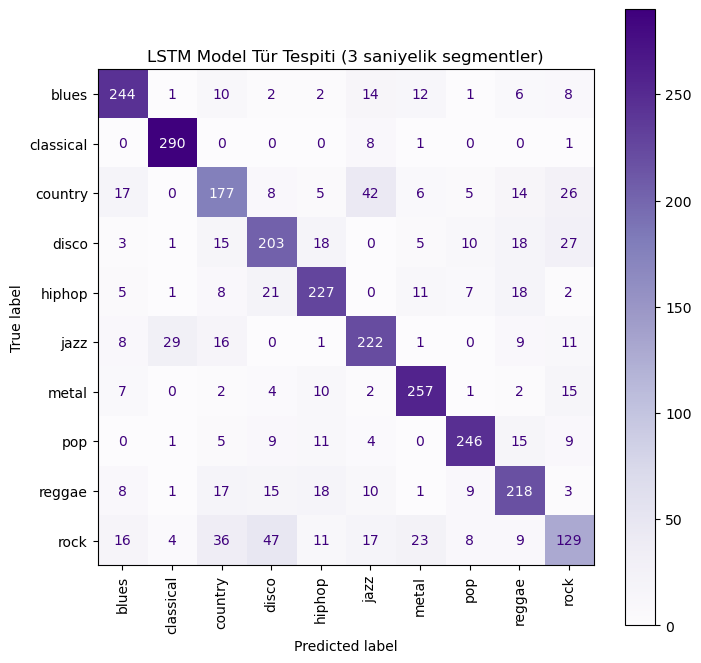

In [9]:
def make_prediction(model, X):
    global genres
    preds_num = []
    preds_name = []

    for X_current in X:
        X_current = X_current[np.newaxis, ...]
        pred = model.predict(X_current)
        pred = np.argmax(pred, axis=1)
        preds_num.append(pred[0])
        preds_name.append(genres[pred[0]])

    return preds_num, preds_name

genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

preds_num, preds_name = make_prediction(model_lstm, X_test)
cm = confusion_matrix(y_test, preds_num)

fig, ax = plt.subplots(figsize=(8,8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=genres)
disp.plot(ax=ax, cmap='Purples', xticks_rotation='vertical')
plt.title('LSTM Model Tür Tespiti (3 saniyelik segmentler)')
plt.show()

In [10]:
model_lstm.save(os.path.join(path, "models/model_lstm.h5"))

In [11]:
from sklearn.metrics import accuracy_score, precision_score, f1_score, classification_report

def evaluate_model(model, X, y_true):
    global genres
    # Tahminleri al
    preds_num, _ = make_prediction(model, X)

    # Genel skorlar
    accuracy = accuracy_score(y_true, preds_num)
    precision_macro = precision_score(y_true, preds_num, average='macro', zero_division=0)
    precision_weighted = precision_score(y_true, preds_num, average='weighted', zero_division=0)
    f1_macro = f1_score(y_true, preds_num, average='macro')
    f1_weighted = f1_score(y_true, preds_num, average='weighted')

    # Genel sonuçları yazdır
    print("🔹 Genel Performans:")
    print(f"Accuracy               : {accuracy:.4f}")
    print(f"Precision (macro)      : {precision_macro:.4f}")
    print(f"Precision (weighted)   : {precision_weighted:.4f}")
    print(f"F1 Score (macro)       : {f1_macro:.4f}")
    print(f"F1 Score (weighted)    : {f1_weighted:.4f}")

    # Sınıf bazlı skorlar
    print("\n🔹 Tür Bazlı Performans (Precision, Recall, F1):")
    report = classification_report(y_true, preds_num, target_names=genres, zero_division=0)
    print(report)

    # Dictionary olarak da döndür
    return classification_report(y_true, preds_num, target_names=genres, output_dict=True, zero_division=0)


metrics = evaluate_model(model_lstm, X_test, y_test)

1/1 [==============================] - 0s 18ms/step
🔹 Genel Performans:
Accuracy               : 0.7384
Precision (macro)      : 0.7329
Precision (weighted)   : 0.7329
F1 Score (macro)       : 0.7344
F1 Score (weighted)    : 0.7344

🔹 Tür Bazlı Performans (Precision, Recall, F1):
              precision    recall  f1-score   support

       blues       0.79      0.81      0.80       300
   classical       0.88      0.97      0.92       300
     country       0.62      0.59      0.60       300
       disco       0.66      0.68      0.67       300
      hiphop       0.75      0.76      0.75       300
        jazz       0.70      0.75      0.72       297
       metal       0.81      0.86      0.83       300
         pop       0.86      0.82      0.84       300
      reggae       0.71      0.73      0.72       300
        rock       0.56      0.43      0.49       300

    accuracy                           0.74      2997
   macro avg       0.73      0.74      0.73      2997
weighted avg   